<a href="https://colab.research.google.com/github/parulnith/Demo1/blob/master/code/Chapter-7/4.Post-Hoc%20Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: Explaining a PyTorch Image Classifier

### Post-Hoc Explanations

## Setting the Environment

In [ ]:
!pip install captum

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random


import copy
import os
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
from skimage.util import random_noise
import time


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_seed = 12345

In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# Importing the Model

Load the double finetuned model. The model can be accessed from [here]()

In [ ]:
model = torch.load('Finetuning_Stage2.pt')
model.eval();

# Importing the test Set

Accessing the preprocessed dataset. Refer to the [Data Preparation](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-7/0.Data%20Preparation.ipynb) notebook 

In [ ]:
PATH = 'chest_xray_pre-processed/chest_xray' 

In [ ]:
testset = ImageFolder(PATH+'/test', 
                           transform=transforms.Compose([transforms.Resize((224,224)), 
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                                                               
                                                 
                                                ]))

In [ ]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device);


# Explaining the Predicitons

In [7]:
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution, DeepLift, InputXGradient,LRP, LayerLRP,GuidedBackprop
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [8]:
classes = dict({0: 'NORMAL',1: 'PNEUMONIA'})

## Predictions

In [9]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])


from matplotlib.colors import LinearSegmentedColormap
def imshow(img, transpose = True):
    plt.figure(figsize = (11,6))
    x = img.cpu() * STD[:, None, None] + MEAN[:, None, None]
    #img = img / 2 + 0.5     # unnormalize
    npimg = x.cpu().numpy()
    plt.imshow(npimg.transpose(1, 2, 0))
    plt.axis('off')
    plt.show()
    


In [ ]:
def pred_image(index):
    dataiter = iter(test_dl)
    images, labels = dataiter.next()
    images = images.to(device)
    labels = labels.to(device)
    ind = index
    input = images[ind].unsqueeze(0)
    input.requires_grad = True
    
    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = classes[pred_label_idx.item()]
    #imshow(images[ind])
    print('Index:',ind)
    print('Ground Truth:',classes[labels[ind].item()])
    print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
    return input, pred_label_idx

# 1. Integrated Gradients

In [ ]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999986886978149 )


/home/paperspace/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


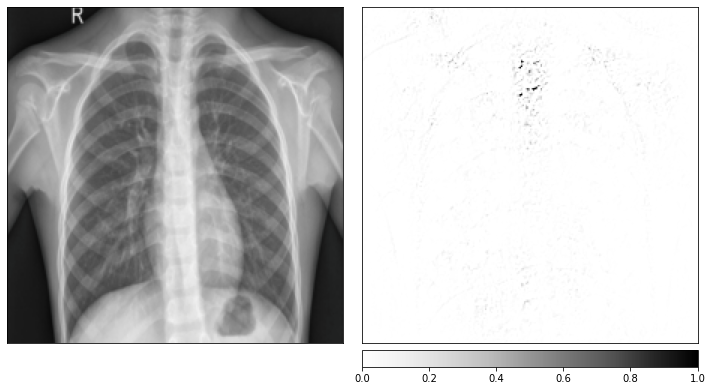

In [ ]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')





In [ ]:
input,pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9998469352722168 )


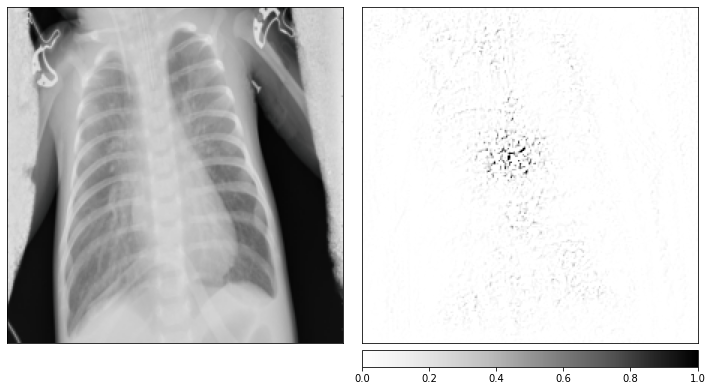

In [ ]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')


# 2. Input X Gradient

In [ ]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999986886978149 )


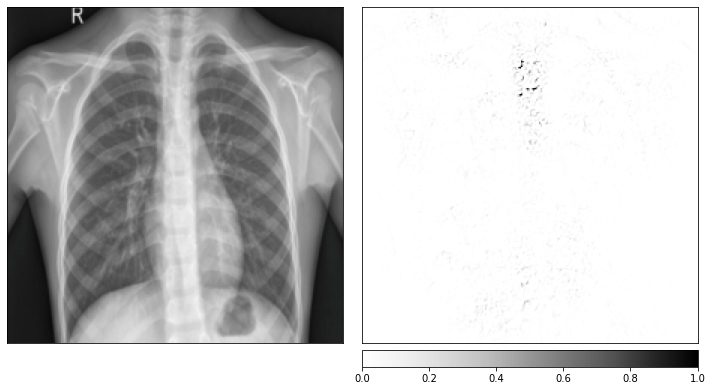

In [ ]:
input_x_gradient = InputXGradient(model)
attribution_ixg = input_x_gradient.attribute(input, target=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_ixg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

In [ ]:
input,pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9998469352722168 )


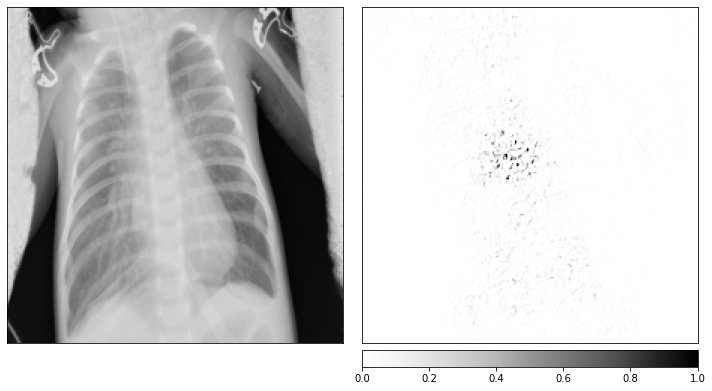

In [ ]:
input_x_gradient = InputXGradient(model)
attribution_ixg = input_x_gradient.attribute(input, target=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_ixg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

# 3. Occlusion

In [ ]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999986886978149 )


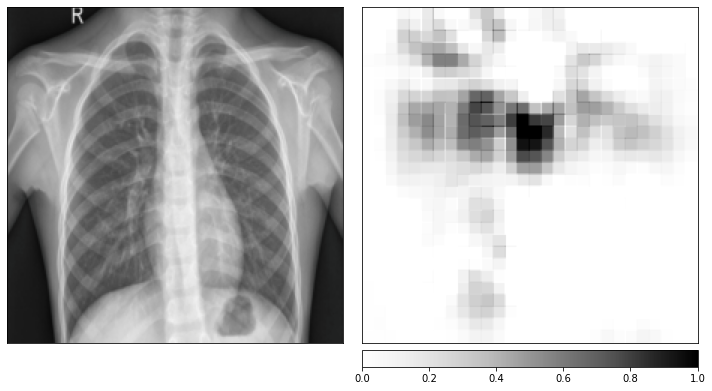

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

In [ ]:
input,pred_label_idx = pred_image(255)

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9998469352722168 )


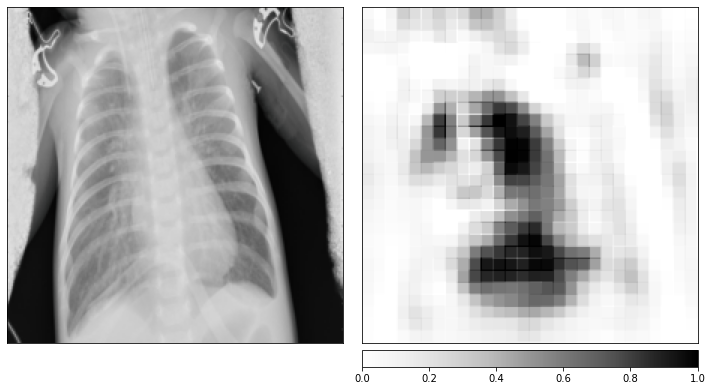

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')




# 4. LRP- Layer-wise relevance propagation


In [ ]:
input,pred_label_idx = pred_image(0)

Index: 0
Ground Truth: NORMAL
Predicted: NORMAL ( 0.9999986886978149 )


/home/paperspace/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


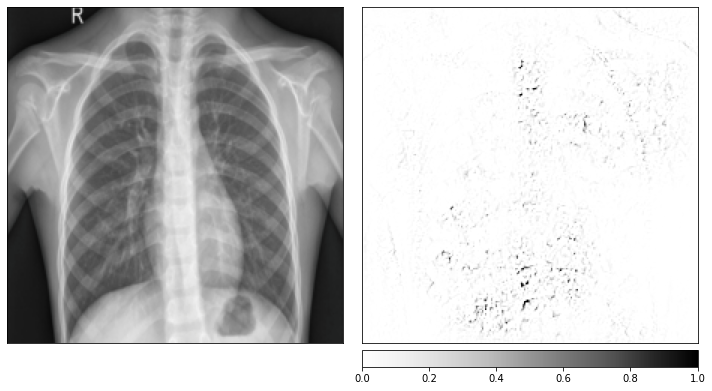

In [ ]:
lrp = LRP(model)
attribution_lrp = lrp.attribute(input, target=0, verbose=False)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')

Index: 255
Ground Truth: PNEUMONIA
Predicted: PNEUMONIA ( 0.9998469352722168 )


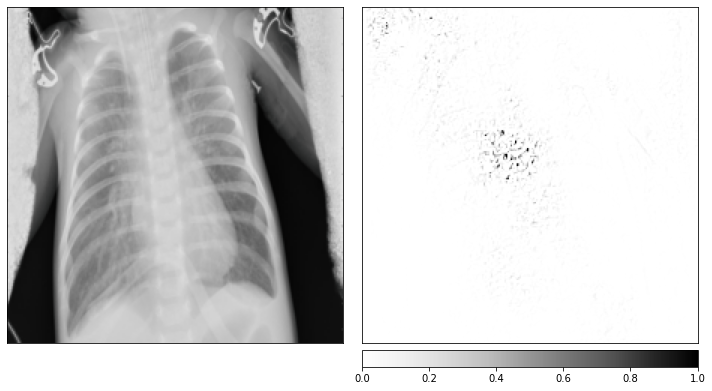

In [ ]:
input,pred_label_idx = pred_image(255)

lrp = LRP(model)
attribution_lrp = lrp.attribute(input, target=0, verbose=False)

_ = viz.visualize_image_attr_multiple(np.transpose(attribution_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose((input.cpu() * STD[:, None, None] + MEAN[:, None, None]).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image","heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      fig_size=(10,8),
                                        cmap='Greys')